## Make Polydiserse Mie Tables

This is a short tutorial on generating optical properties for polydisperse mie size distributions.
It follows from MakeMieTables tutorial notebook.

This tutorial describes an intermediate step that is typically hidden from the user when creating optical properties if the `at3d.medium.OpticalPropertyGenerator` is used directly. See the MakingOpticalProperties notebook.

In [2]:
#imports

import at3d
import numpy as np
import xarray as xr

### Get a mono table.

If this was already saved from the other tutorial then this is quick, otherwise it will take some time.

In [2]:

mie_mono_table = at3d.mie.get_mono_table(
    'Water',(0.86,0.86),
    max_integration_radius=65.0,
    minimum_effective_radius=0.1,
    relative_dir='../mie_tables',
    verbose=False
)


### Define the size distribution function

Only two sizes distributions are currently implemented in at3d, though it is simple enough to add more.
All that is required is to define a function that evaluates the size distribution.
Here we use the already implemented gamma size distribution (`at3d.size_distribution.gamma`).

Note that the default normalization condition for size distributions generated by SHDOM is to have unit liquid water content in $g / m^3$. There are a number of different normalization options available including  unit geometric extinction in $km^{-1}$, or unit droplet number concentration in $cm^{-3}$. Currently, the only way to access the normalization options is to form a partial wrapper of the size distribution callable with the appropriate normalization option selected. This is done automatically by the `at3d.medium.OpticalPropertyGenerator` as described in the MakingOpticalProperties notebook.

As you can see below, `at3d.size_distribution.gamma` is parameterized by an effective radius (`reff`) and either 
a shape parameter (`alpha`) or an effective variance (`veff`).

In [5]:
help(at3d.size_distribution.gamma)

Help on function gamma in module at3d.size_distribution:

gamma(radii, reff, veff=None, alpha=None, particle_density=1.0, normalization='density')
    Generate a Gamma size distribution.
    Provide either effective variance `veff` or shape parameter `alpha`.
    
    Parameters
    ----------
    radii: scalar, list/numpy array
        Radii of precomputed Mie tables in `radius units`.
    reff: scalar, list/numpy array
        Effective radius for which to compute the size distribution.
    veff: scalar, list/numpy array
        Effective variance of the size distribution in `radius units`.
        The larger this parameter, the broader the size distribution.
    alpha: scalar, list/numpy array
        Shape parameter.
    particle_density: float
        Particle density in [g/m^3]. Default 1 g/m^3 for Water.
    normalization: str
        Choice of size distribution normalization from
        `density` [g/m^3], `geometric_extinction` [1/km]
        (extinction calculated using a fix

In [4]:
# This usage of functools is done automatically 
# Note that the update_wrapper is required as the size distribution callable
# must have a __name__ attribute.
import functools
size_distribution_function = functools.update_wrapper(
            functools.partial(at3d.size_distribution.gamma, 
                              normalization='geometric_extinction'),
            at3d.size_distribution.gamma
        )

help(size_distribution_function)

Help on partial in module at3d.size_distribution:

gamma = functools.partial(<function gamma at 0x16bf77dc0>, normalization='geometric_extinction')
    Generate a Gamma size distribution.
    Provide either effective variance `veff` or shape parameter `alpha`.
    
    Parameters
    ----------
    radii: scalar, list/numpy array
        Radii of precomputed Mie tables in `radius units`.
    reff: scalar, list/numpy array
        Effective radius for which to compute the size distribution.
    veff: scalar, list/numpy array
        Effective variance of the size distribution in `radius units`.
        The larger this parameter, the broader the size distribution.
    alpha: scalar, list/numpy array
        Shape parameter.
    particle_density: float
        Particle density in [g/m^3]. Default 1 g/m^3 for Water.
    normalization: str
        Choice of size distribution normalization from
        `density` [g/m^3], `geometric_extinction` [1/km]
        (extinction calculated using a fi

### Generating the Size Distributions

We can use the `at3d.size_distribution.get_size_distribution_grid` method to generate size distributions.
It takes the `size_distribution_function` as an argument which must be a callable. We then pass the required 
parameters for the size distribution as key word arguments, in this case the parameters are the `reff` and `veff`.

In [8]:
size_distribution = at3d.size_distribution.get_size_distribution_grid(
    mie_mono_table.radius,
    size_distribution_function=at3d.size_distribution.gamma,
    particle_density=1.0, radius_units='micron',
    reff=np.linspace(5.0,20.0,16),
    veff=np.ones(1)*0.1)

In [10]:
size_distribution

<xarray.Dataset>
Dimensions:         (radius: 1444, reff: 16, veff: 1)
Coordinates:
  * radius          (radius) float32 0.002 0.003369 0.004737 ... 64.97 65.06
  * reff            (reff) float64 5.0 6.0 7.0 8.0 9.0 ... 17.0 18.0 19.0 20.0
  * veff            (veff) float64 0.1
Data variables:
    number_density  (radius, reff, veff) float32 1.023e-20 ... 5.284e-08
Attributes:
    distribution_type:  gamma
    radius_units:       radius units [micron]

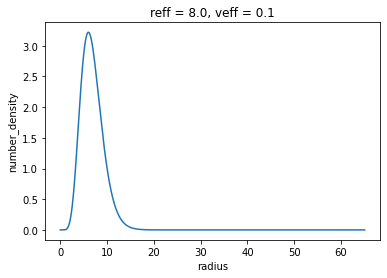

In [12]:
size_distribution.number_density.sel(reff=8.0).plot()

### Making the Polydisperse Mie Table

Now all we have to do is put the size distribution and the mono disperse Mie table together using the `at3d.mie.get_poly_table` method.

In [15]:
poly_table = at3d.mie.get_poly_table(size_distribution, mie_mono_table)
poly_table

<xarray.Dataset>
Dimensions:       (legendre_index: 1017, reff: 16, stokes_index: 6, veff: 1)
Coordinates:
  * reff          (reff) float64 5.0 6.0 7.0 8.0 9.0 ... 17.0 18.0 19.0 20.0
  * veff          (veff) float64 0.1
    table_index   (reff, veff) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * stokes_index  (stokes_index) object 'P11' 'P22' 'P33' 'P44' 'P12' 'P34'
Dimensions without coordinates: legendre_index
Data variables:
    extinction    (reff, veff) float32 329.6 271.7 231.0 ... 86.74 82.06 77.85
    ssalb         (reff, veff) float32 1.0 1.0 1.0 1.0 ... 0.9999 0.9999 0.9999
    legcoef       (stokes_index, legendre_index, reff, veff) float32 1.0 ... ...
Attributes:
    distribution_type:           gamma
    radius_units:                radius units [micron]
    particle_type:               Water
    refractive_index:            [ 1.33000004e+00 -2.89324419e-07]
    refractive_index_source:     src/polarized/indexwatice.f
    units:                       ['Radius [micron]', 'Wavelength [micron]']
    wavelength_band:             [0.86 0.86]
    wavelength_center:           0.8600000143051147
    wavelength_averaging:        False
    wavelength_resolution:       0.001
    maximum_legendre:            1016
    minimum_effective_radius:    0.1
    maximum_integration_radius:  65.0

### Visualization

We can use the same utility function to visualize the polydisperse phase functions.

In [17]:


phase_function = at3d.util.get_phase_function(poly_table.legcoef[...,0], np.linspace(0.0,180.0,360), phase_elements='All')

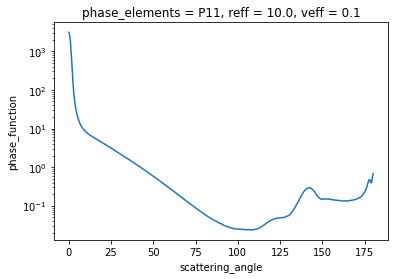

In [22]:
phase_function[0,:,5].plot(yscale='log')